## Overview

Q: How much does it cost to cool a skyscraper in the summer?
A: A lot! And not just in dollars, but in environmental impact.

Thankfully, significant investments are being made to improve building efficiencies to reduce costs and emissions. The question is, are the improvements working? That’s where you come in. Under pay-for-performance financing, the building owner makes payments based on the difference between their real energy consumption and what they would have used without any retrofits. The latter values have to come from a model. Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

In this notebook, we will develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

## Data

Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best we can do is to build counterfactual models. Once a building is overhauled the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing.

This challenges you to build these counterfactual models across four energy types based on historic usage rates and observed weather. The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

## Files

**train.csv**
1. building_id - Foreign key for the building metadata.
2. meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
3. timestamp - When the measurement was taken
4. meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

**building_meta.csv**
1. site_id - Foreign key for the weather files.
2. building_id - Foreign key for training.csv
3. primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
4. square_feet - Gross floor area of the building
5. year_built - Year building was opened
6. floor_count - Number of floors of the building

**weather_[train/test].csv**

Weather data from a meteorological station as close as possible to the site.

1. site_id
2. air_temperature - Degrees Celsius
3. cloud_coverage - Portion of the sky covered in clouds, in oktas
4. dew_temperature - Degrees Celsius
5. precip_depth_1_hr - Millimeters
6. sea_level_pressure - Millibar/hectopascals
7. wind_direction - Compass direction (0-360)
8. wind_speed - Meters per second

**test.csv**

The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

1. row_id - Row id for your submission file
2. building_id - Building id code
3. meter - The meter id code
4. timestamp - Timestamps for the test data period

## So lets begin with complete EDA...

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


## Load Data

In [2]:
building_df = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")
weather_train = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")
train = pd.read_csv("../input/ashrae-energy-prediction/train.csv")

### Features that are likely predictive:

**Buildings**
* primary_use
* square_feet
* year_built
* floor_count (may be too sparse to use)

**Weather**
* time of day
* holiday
* weekend
* cloud_coverage + lags
* dew_temperature + lags
* precip_depth + lags
* sea_level_pressure + lags
* wind_direction + lags
* wind_speed + lags

**Train**
* max, mean, min, std of the specific building historically
* number of meters
* number of buildings at a siteid

In [3]:
building_df

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [4]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [5]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [6]:
train = train.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")

In [8]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

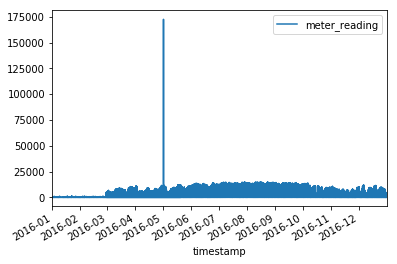

In [9]:
# looks like there may be some errors with some of the readings
train[train["site_id"] == 0].plot("timestamp", "meter_reading")

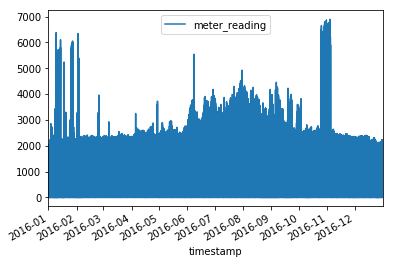

In [10]:
train[train["site_id"] == 2].plot("timestamp", "meter_reading")

In [11]:
train[["hour", "day", "weekend", "month"]]

,hour,day,weekend,month
0,0,1,4,1
1,0,1,4,1
2,0,1,4,1
3,0,1,4,1
4,0,1,4,1
...,...,...,...,...
20216095,23,31,5,12
20216096,23,31,5,12
20216097,23,31,5,12
20216098,23,31,5,12


In [12]:
train = train.drop("timestamp", axis = 1)

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
le = LabelEncoder()
train["primary_use"] = le.fit_transform(train["primary_use"])

In [15]:
categoricals = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]

In [16]:
train

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month
0,0,0,0.000,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
1,1,0,0.000,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
2,2,0,0.000,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
3,3,0,0.000,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
4,4,0,0.000,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750,15,1,19619,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,23,31,5,12
20216096,1445,0,4.825,15,0,4298,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,23,31,5,12
20216097,1446,0,0.000,15,1,11265,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,23,31,5,12
20216098,1447,0,159.575,15,4,29775,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,23,31,5,12


In [17]:
drop_cols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]
numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature"]

In [19]:
train[categoricals + numericals]

,building_id,primary_use,hour,day,weekend,month,meter,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature
0,0,0,0,1,4,1,0,7432,2008.0,25.0,6.0,20.0
1,1,0,0,1,4,1,0,2720,2004.0,25.0,6.0,20.0
2,2,0,0,1,4,1,0,5376,1991.0,25.0,6.0,20.0
3,3,0,0,1,4,1,0,23685,2002.0,25.0,6.0,20.0
4,4,0,0,1,4,1,0,116607,1975.0,25.0,6.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,1,23,31,5,12,0,19619,1914.0,1.7,NaN,-5.6
20216096,1445,0,23,31,5,12,0,4298,NaN,1.7,NaN,-5.6
20216097,1446,1,23,31,5,12,0,11265,1997.0,1.7,NaN,-5.6
20216098,1447,4,23,31,5,12,0,29775,2001.0,1.7,NaN,-5.6


In [20]:
feat_cols = categoricals + numericals

In [21]:
train["meter_reading"].value_counts()

0.0000       1873976
20.0000        23363
2.9307         23181
36.6000        22154
8.7921         21787
              ...   
72.6357            1
2977.7000          1
55.4186            1
2977.4500          1
15.3563            1
Name: meter_reading, Length: 1688175, dtype: int64

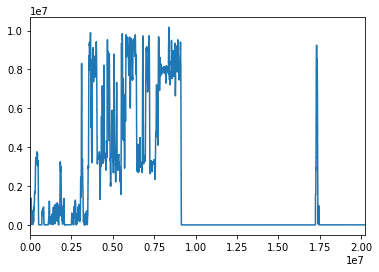

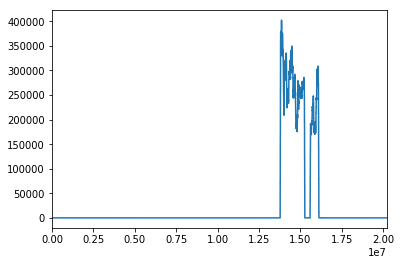

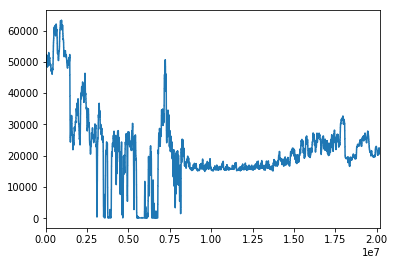

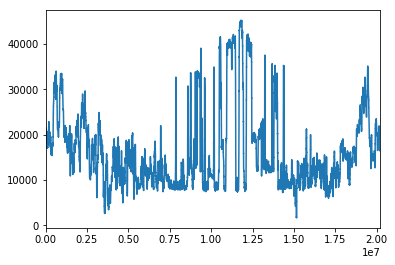

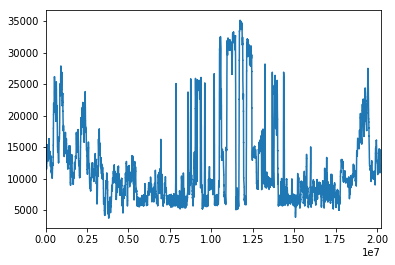

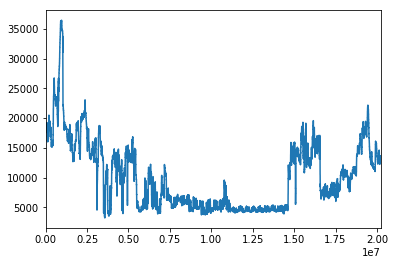

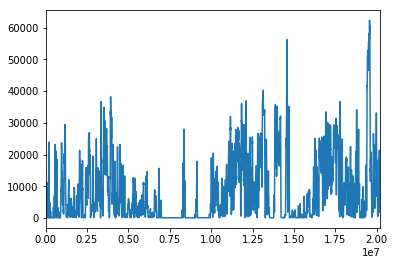

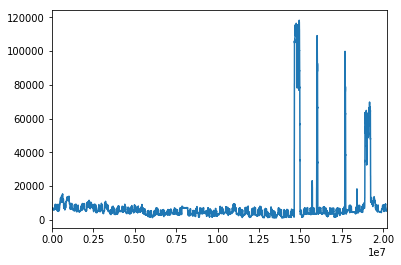

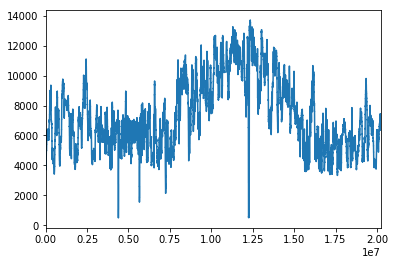

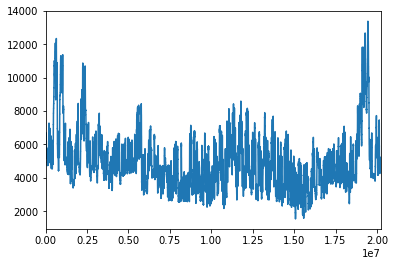

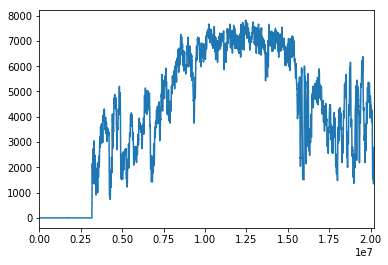

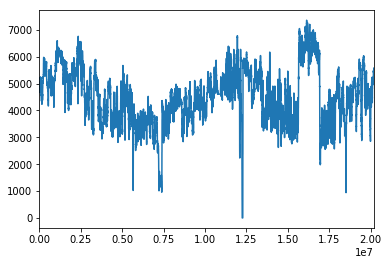

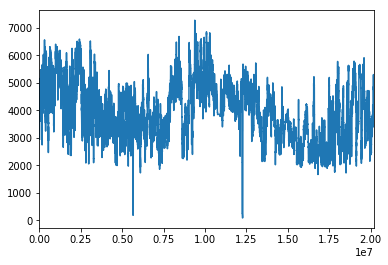

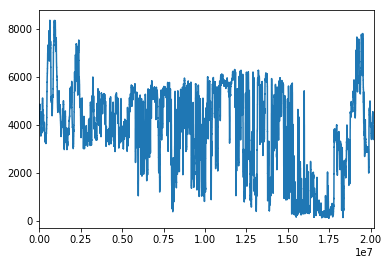

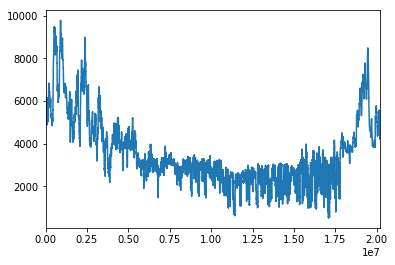

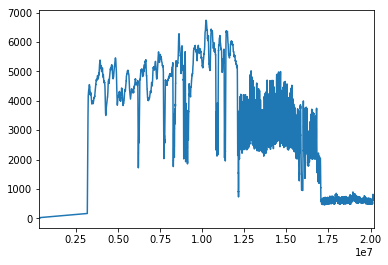

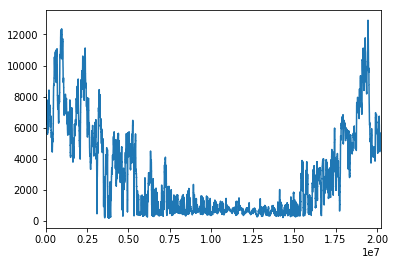

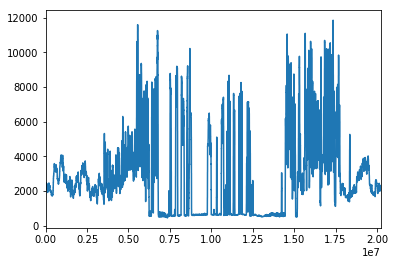

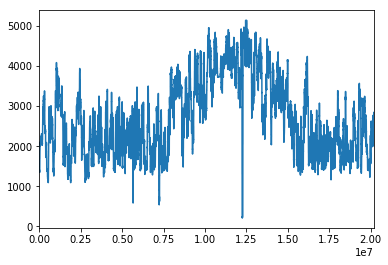

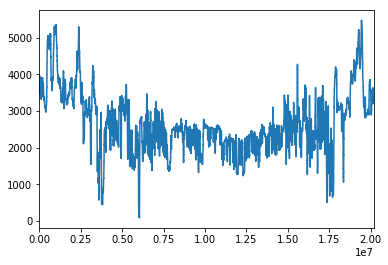

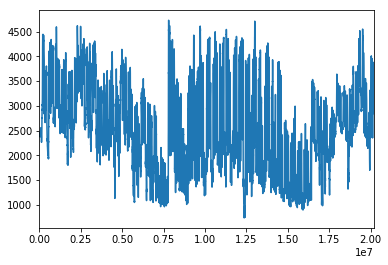

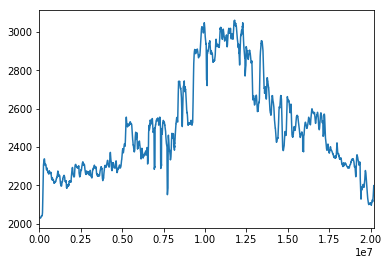

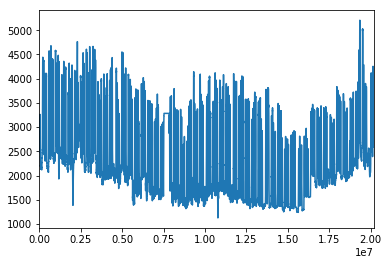

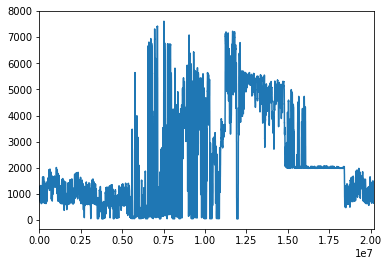

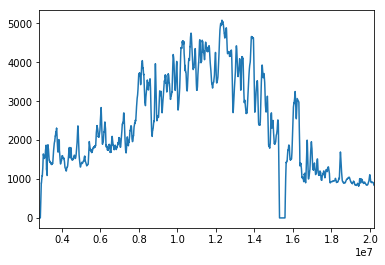

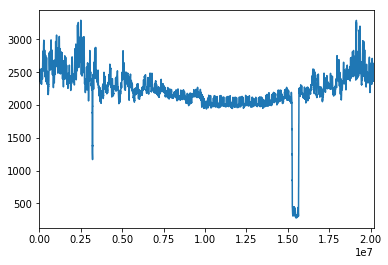

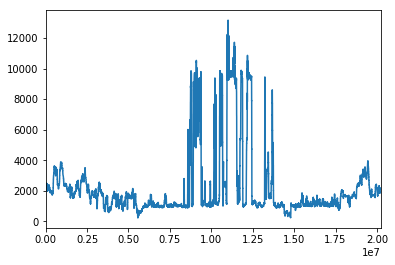

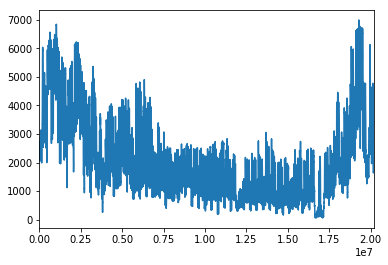

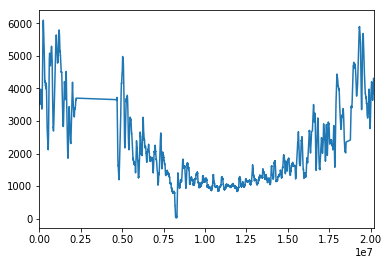

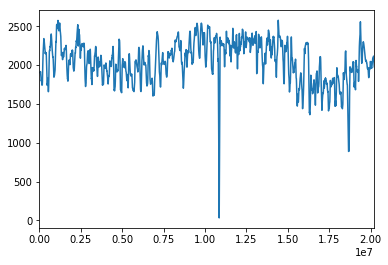

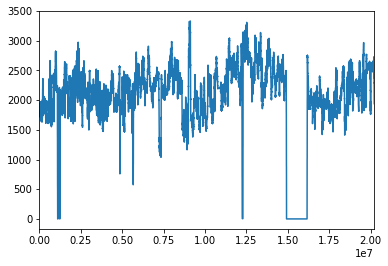

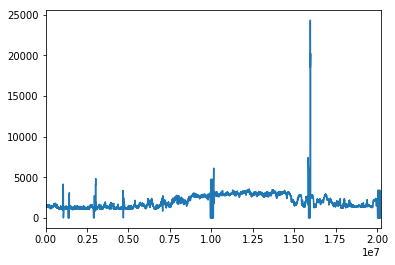

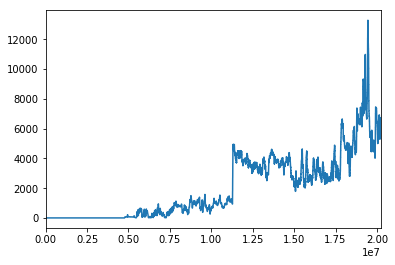

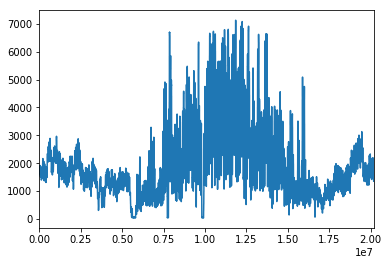

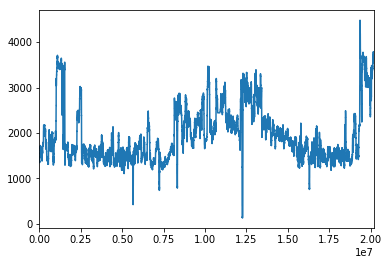

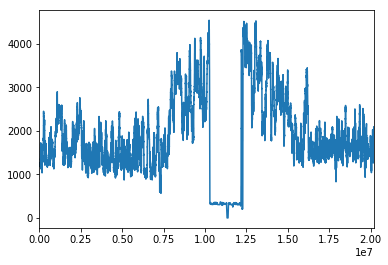

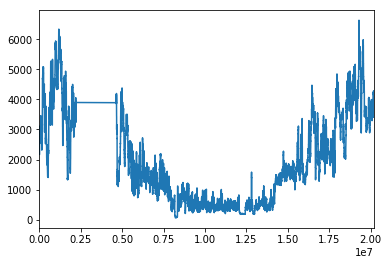

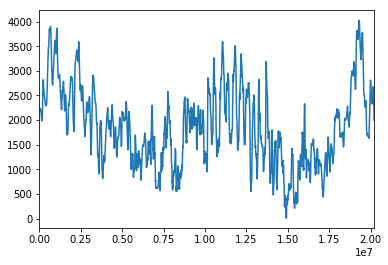

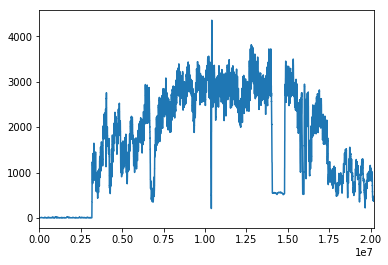

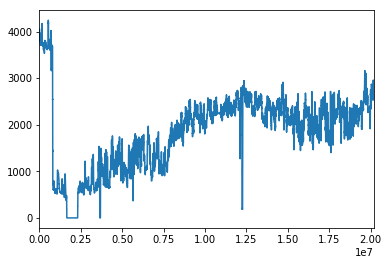

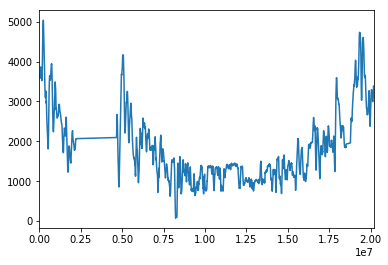

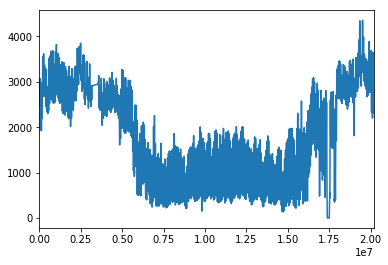

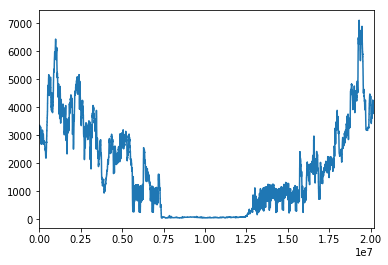

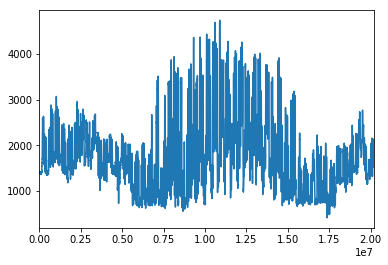

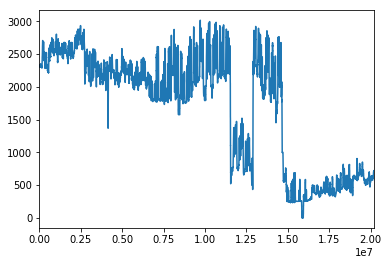

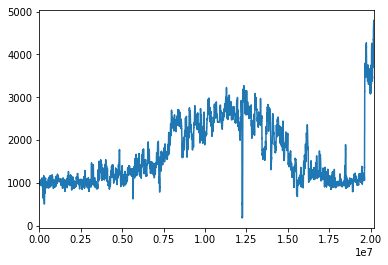

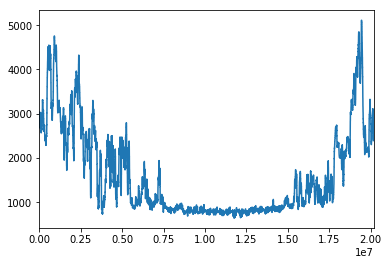

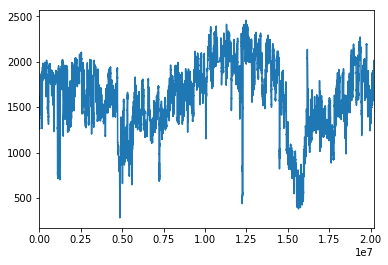

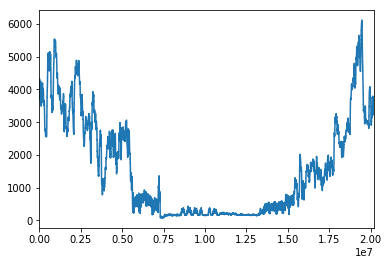

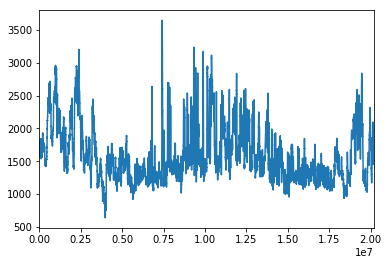

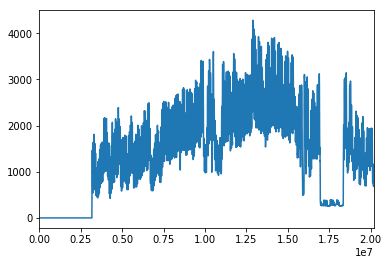

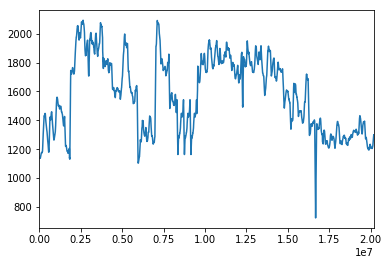

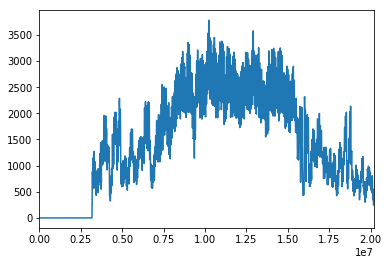

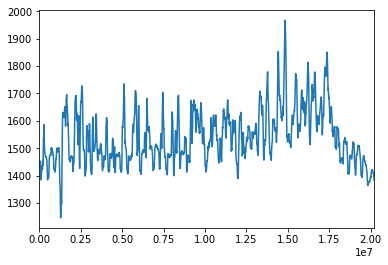

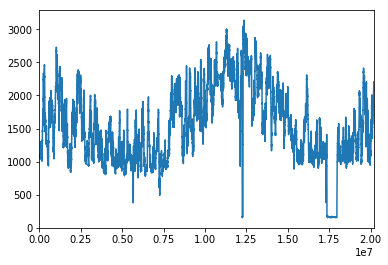

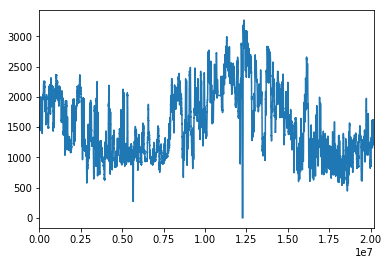

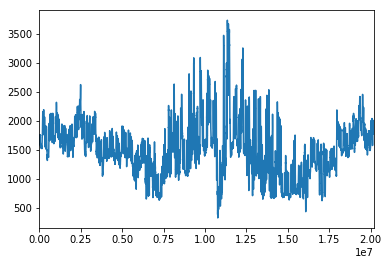

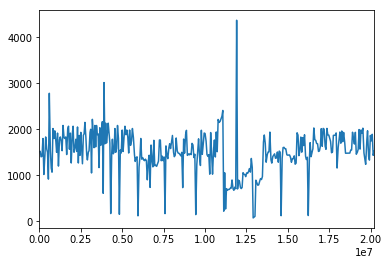

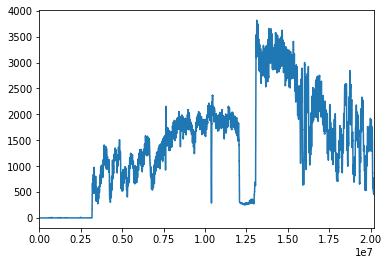

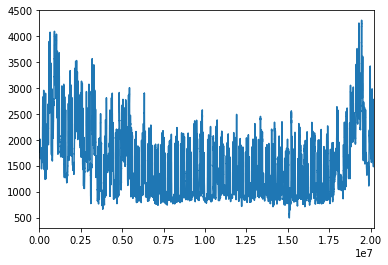

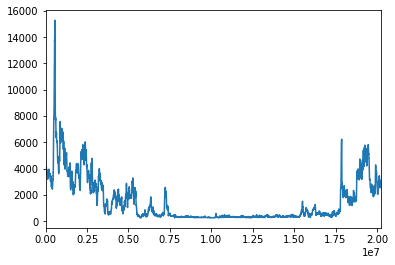

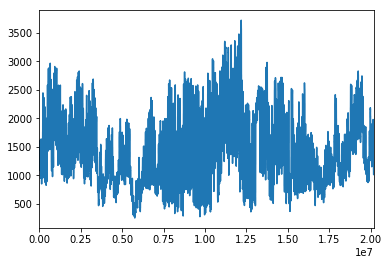

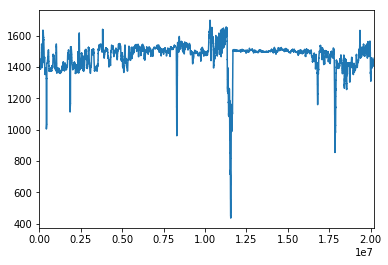

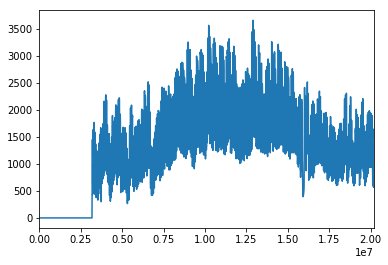

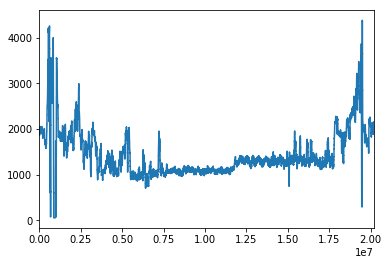

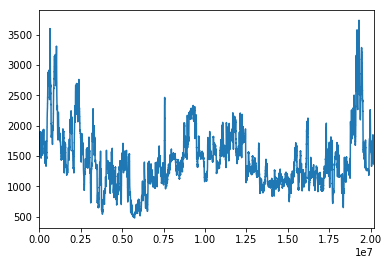

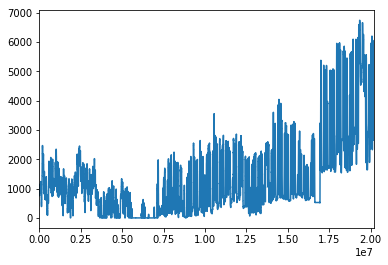

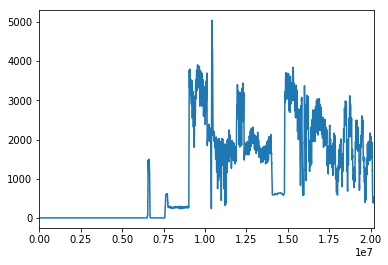

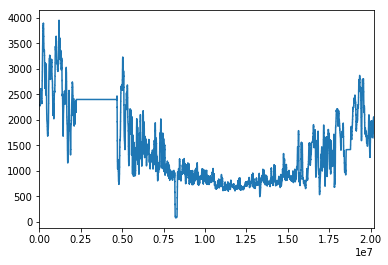

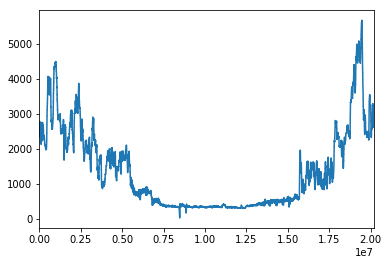

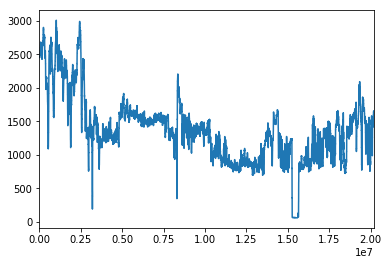

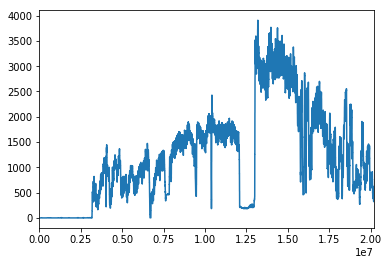

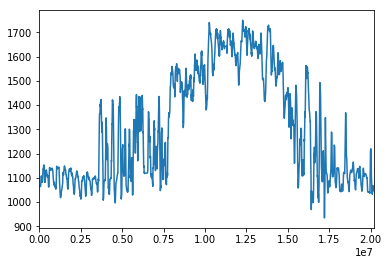

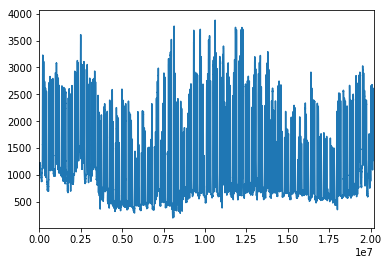

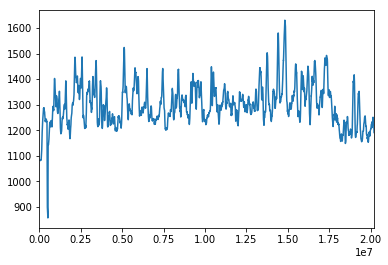

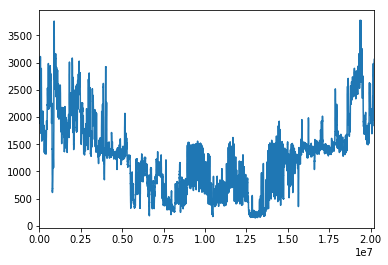

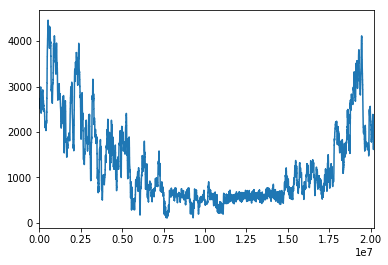

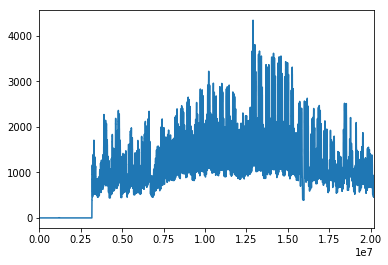

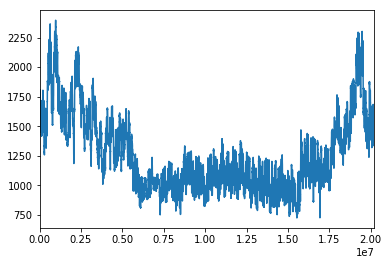

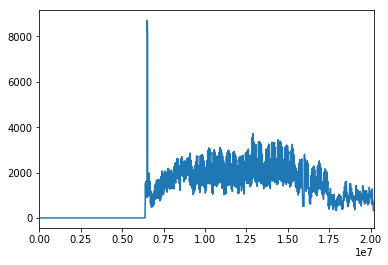

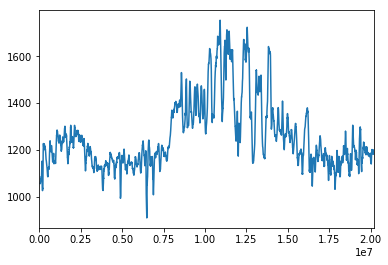

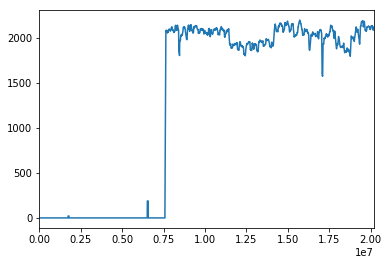

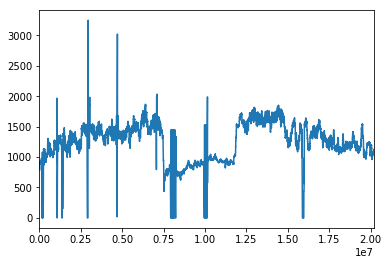

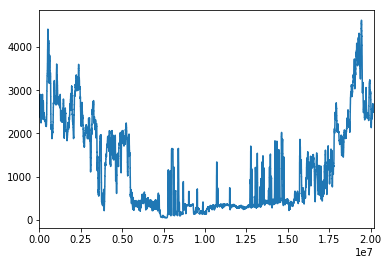

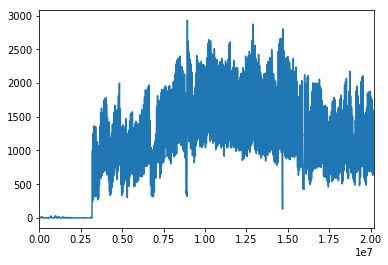

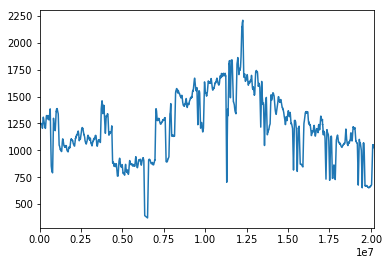

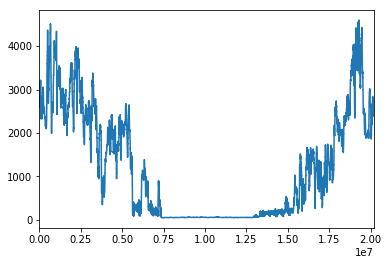

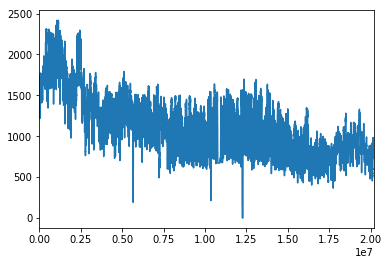

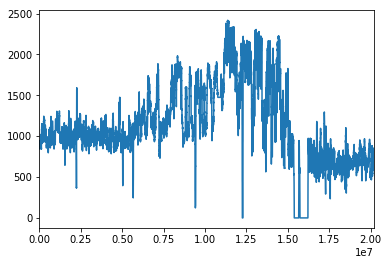

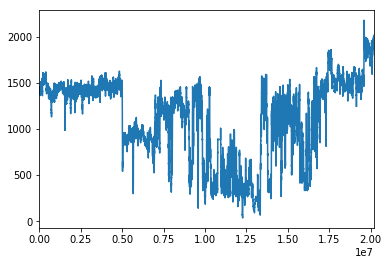

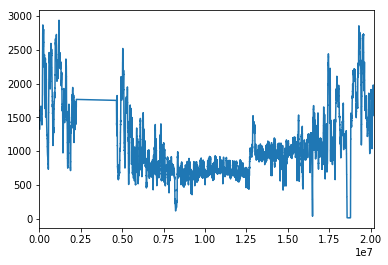

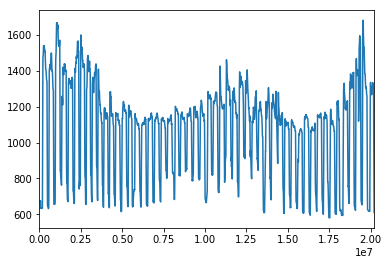

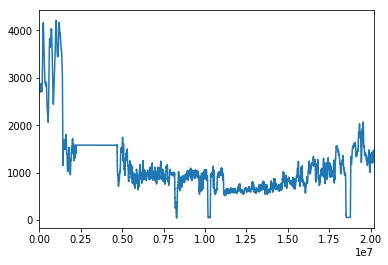

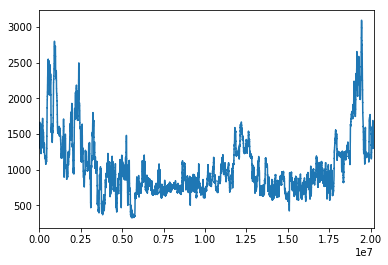

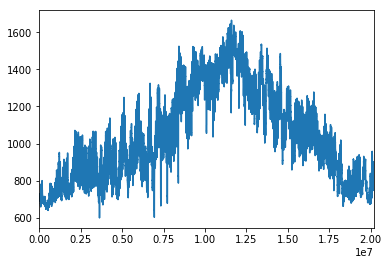

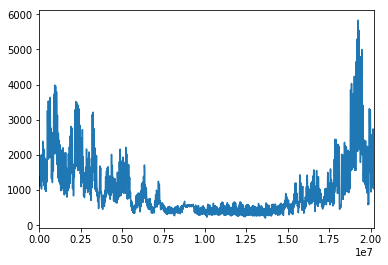

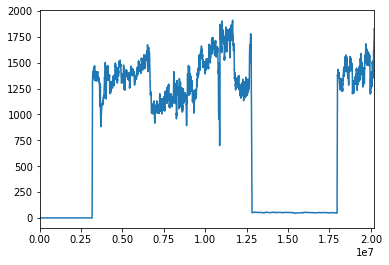

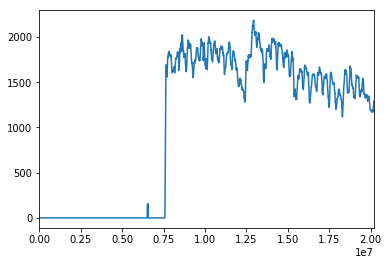

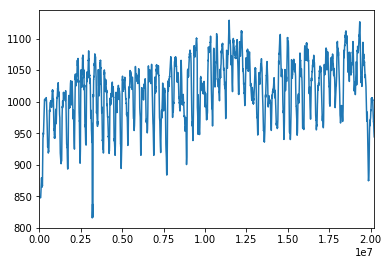

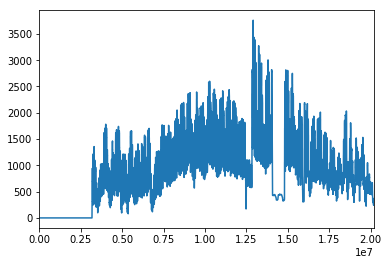

In [22]:
import matplotlib.pyplot as plt
top_buildings = train.groupby("building_id")["meter_reading"].mean().sort_values(ascending = False).iloc[:100]
for value in top_buildings.index:
     train[train["building_id"] == value]["meter_reading"].rolling(window = 24).mean().plot()
     plt.show()

In [23]:
target = np.log1p(train["meter_reading"])
del train["meter_reading"]
train = train.drop(drop_cols + ["site_id", "floor_count"], axis = 1)

In [26]:
train

,building_id,meter,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,hour,day,weekend,month
0,0,0,0,7432,2008.0,25.0,6.0,20.0,0,1,4,1
1,1,0,0,2720,2004.0,25.0,6.0,20.0,0,1,4,1
2,2,0,0,5376,1991.0,25.0,6.0,20.0,0,1,4,1
3,3,0,0,23685,2002.0,25.0,6.0,20.0,0,1,4,1
4,4,0,0,116607,1975.0,25.0,6.0,20.0,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,1,19619,1914.0,1.7,NaN,-5.6,23,31,5,12
20216096,1445,0,0,4298,NaN,1.7,NaN,-5.6,23,31,5,12
20216097,1446,0,1,11265,1997.0,1.7,NaN,-5.6,23,31,5,12
20216098,1447,0,4,29775,2001.0,1.7,NaN,-5.6,23,31,5,12


In [27]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [28]:
train, NAlist = reduce_mem_usage(train)

Memory usage of properties dataframe is : 2005.0758361816406  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for this col:  875000
dtype after:  uint32
******************************
******************************
Column:  year_built
dtype before:  float64
min for this col:  1900.0
max for this col:  2017.0
dtype after:  uint16
******************************
******************************
Column:  air_temperature
dtype before:  float64
min for

## LightGBM

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = False, random_state = 42)
error = 0
models = []
for i, (train_index, val_index) in enumerate(kf.split(train)):
    if i + 1 < num_folds:
        continue
    print(train_index.max(), val_index.min())
    train_X = train[feat_cols].iloc[train_index]
    val_X = train[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y > 0)
    lgb_eval = lgb.Dataset(val_X, val_y > 0)
    params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_class = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
    
    lgb_train = lgb.Dataset(train_X[train_y > 0], train_y[train_y > 0])
    lgb_eval = lgb.Dataset(val_X[val_y > 0] , val_y[val_y > 0])
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.5,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_regress = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
#     models.append(gbm)

    y_pred = (gbm_class.predict(val_X, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(val_X, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(y_pred, (val_y)))/num_folds
    print(np.sqrt(mean_squared_error(y_pred, (val_y))))
    break
print(error)

16172879 16172880
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.179465	valid_1's binary_logloss: 0.179322
[40]	training's binary_logloss: 0.157622	valid_1's binary_logloss: 0.175654
[60]	training's binary_logloss: 0.146057	valid_1's binary_logloss: 0.172846
[80]	training's binary_logloss: 0.137743	valid_1's binary_logloss: 0.173728
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.144102	valid_1's binary_logloss: 0.172487
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.872481	valid_1's rmse: 0.933909
[40]	training's rmse: 0.765797	valid_1's rmse: 0.861977
[60]	training's rmse: 0.703914	valid_1's rmse: 0.808794
[80]	training's rmse: 0.658989	valid_1's rmse: 0.784859
[100]	training's rmse: 0.619144	valid_1's rmse: 0.767098
[120]	training's rmse: 0.59556	valid_1's rmse: 0.758259
[140]	training's rmse: 0.57568	valid_1's rmse: 0.746786
[160]	training's rmse: 0.558876	valid_1's rmse: 0.72

In [30]:
sorted(zip(gbm_regress.feature_importance(), gbm_regress.feature_name()),reverse = True)

[(2349, 'building_id'),
 (2111, 'square_feet'),
 (1085, 'meter'),
 (803, 'primary_use'),
 (767, 'year_built'),
 (740, 'month'),
 (680, 'hour'),
 (514, 'air_temperature'),
 (253, 'dew_temperature'),
 (205, 'weekend'),
 (158, 'day'),
 (25, 'cloud_coverage')]

In [31]:
import gc
del train
del train_X, val_X, lgb_train, lgb_eval, train_y, val_y, y_pred, target

In [32]:
gc.collect()

7550

In [33]:
#preparing test data
test = pd.read_csv("../input/ashrae-energy-prediction/test.csv")
test = test.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
del building_df
gc.collect()

0

In [34]:
test

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN
...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,15,Entertainment/public assembly,19619,1914.0,NaN
41697596,41697596,1445,0,2018-05-09 07:00:00,15,Education,4298,NaN,NaN
41697597,41697597,1446,0,2018-05-09 07:00:00,15,Entertainment/public assembly,11265,1997.0,NaN
41697598,41697598,1447,0,2018-05-09 07:00:00,15,Lodging/residential,29775,2001.0,NaN


In [35]:
test["primary_use"] = le.transform(test["primary_use"])

In [36]:
test, NAlist = reduce_mem_usage(test)

Memory usage of properties dataframe is : 3181.2744140625  MB
******************************
Column:  row_id
dtype before:  int64
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for this 

In [37]:
test

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01 00:00:00,0,0,7432,2008,0
1,1,1,0,2017-01-01 00:00:00,0,0,2720,2004,0
2,2,2,0,2017-01-01 00:00:00,0,0,5376,1991,0
3,3,3,0,2017-01-01 00:00:00,0,0,23685,2002,0
4,4,4,0,2017-01-01 00:00:00,0,0,116607,1975,0
...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,15,1,19619,1914,0
41697596,41697596,1445,0,2018-05-09 07:00:00,15,0,4298,1899,0
41697597,41697597,1446,0,2018-05-09 07:00:00,15,1,11265,1997,0
41697598,41697598,1447,0,2018-05-09 07:00:00,15,4,29775,2001,0


In [38]:
gc.collect()

0

In [39]:
weather_test = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv")
weather_test = weather_test.drop(drop_cols, axis = 1)

In [40]:
weather_test

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature
0,0,2017-01-01 00:00:00,17.8,4.0,11.7
1,0,2017-01-01 01:00:00,17.8,2.0,12.8
2,0,2017-01-01 02:00:00,16.1,0.0,12.8
3,0,2017-01-01 03:00:00,17.2,0.0,13.3
4,0,2017-01-01 04:00:00,16.7,2.0,13.3
...,...,...,...,...,...
277238,15,2018-12-31 19:00:00,3.3,NaN,1.7
277239,15,2018-12-31 20:00:00,2.8,NaN,1.1
277240,15,2018-12-31 21:00:00,2.8,NaN,1.7
277241,15,2018-12-31 22:00:00,2.8,NaN,2.2


In [41]:
test = test.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")
del weather_test

In [42]:
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = test["timestamp"].dt.hour.astype(np.uint8)
test["day"] = test["timestamp"].dt.day.astype(np.uint8)
test["weekend"] = test["timestamp"].dt.weekday.astype(np.uint8)
test["month"] = test["timestamp"].dt.month.astype(np.uint8)
test = test[feat_cols]

In [43]:
from tqdm import tqdm
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test.shape[0]/50000)))):
    
    res.append(np.expm1((gbm_class.predict(test.iloc[i:i+step_size], num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(test.iloc[i:i+step_size], num_iteration=gbm_regress.best_iteration))))
    i+=step_size

100%|██████████| 834/834 [07:07<00:00,  1.95it/s]


In [44]:
del test
res = np.concatenate(res)

In [46]:
pd.DataFrame(res).describe()

,0
count,4.169760e+07
mean,1.046305e+03
std,6.749480e+04
min,-9.467108e-01
25%,2.454626e+01
50%,8.412281e+01
75%,2.586173e+02
max,2.592061e+07


In [47]:
res.shape

(41697600,)

In [48]:
sub = pd.read_csv("../input/ashrae-energy-prediction/sample_submission.csv")
sub["meter_reading"] = res
sub.to_csv("submission.csv", index = False)